# **AI 4 climate summer school: Day 2**
# **Tutorial: Seasonal Forecasting**


#Setup/ Logistics


*   **Sharing**: Based on sharing permissions, you should not be allowed to make edits to the shared Colab notebook directly.  In order to make edits to this notebook, you should press File > "Save a Copy in Drive".

*   **Terminology** : in the intro to AI lecture, the terms *input* and *label* were introduced.  Here, call the input to the ML model as *predictor*, and we refer to the label as the *predictand*.  In this notebook, the inputs are sea surface temperatures, and the labels are an index measuring the future state of El Nino.



## Introduction

El Niño/ Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  

ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomously cold temperatures.  Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors, such as agriculture, and energy.

Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction.

In this notebook, we will issue ENSO forecasts using machine learning models.



## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is *strongly* recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data



*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.




### Input Variables

Sea surface temperature (K)

### Output Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



We will divide the data set in training and validation set.

### Training Set

Baseline training set: Training on **1980-1995 sea Surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 months)

### Val Set
**1997-2006 sea surface temperatures** and their corresponding Nino3.4 Index at lead times.

### Test Set:

Test on **2007-2017 sea surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 month).


### Machine Learning Fundamentals

In this section, we will cover the fundamentals of machine learning!  We will refer to chapters from Professor Jonathan Shewchuk's excellent lecture notes from CS189 (UC Berkeley's Machine Learning class) as well as course notes developed by TAs including Garrett Thomas and Soroush Nasiriany. These notes provide a rigorous mathematical basis of the foundations of machine learning, and they are very helpful for developing the intuition behind tackling machine learning problems.  If you are interested in going deeper into machine learning, I strongly recommend reading these two resources.

*   Professor Shewchuk's lecture notes can be found at this [link ](https://people.eecs.berkeley.edu/~jrs/papers/machlearn.pdf)
*   Nasiriany and Thomas's course notes can be found at this [link ](http://snasiriany.me/files/ml-book.pdf)

In [ ]:
#Download the required packages that we will use for this tutorial

!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.4 MB/s eta 0:00:00


In [2]:
#Download the data with wget
#!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
#!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

--2025-05-07 13:50:45--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.106, 128.55.206.107, 128.55.206.108, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:80... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2025-05-07 13:50:45--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  71.9MB/s    in 6.1s    

2025-05-07 13:50:51 (67.9 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc’ s

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time,
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    #TODO: create an option to apply the PCA operation learned
    #on the train set to the test set.  Currently, PCA is performed
    #independently on the train set and test set.
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


In [ ]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


# Baseline Machine Learning Model


The baseline ML model will be linear regression.



RMSE: 0.28


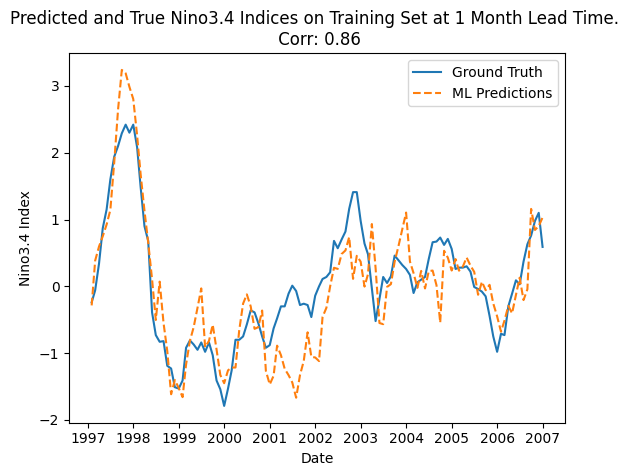

In [ ]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## Metrics

The metrics for evaluating this ML model are

*  Pearson correlation
*   RMSE

The above code snippet includes examples of calculating them.

## Key Terms



Some terms:
*   predictor     : the input to a machine learning model: a certain number of months (that you define) of gridded temperature)
*   predictand    : the true value the model is trying to predict (i.e. the true Niño3.4 index)
*   prediction    : the output of the machine learning model




##Train/Val/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the label).  
*   At this workshop, our predictors have been anomalized global temperature, and our predictand has been the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time.  

Let's call our predictors $X$, and let's call our predictand $y$.  There is some unknown relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index.  The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set and a test set.


*   During training, the ML model is shown the predictors and their associated predictands.  The ML model uses optimization to learn a function: given the training predictors, the function outputs the predictands as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. the test set). When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
*   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.



***Question***: In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




In the next code cell, let's study overfitting in the following task: training a machine learning model to forecast El Niño.  El Niño is a cycle of warm and cold temperatures in the equatorial Pacific Ocean that has broad implications for seasonal weather.

The code cell below demonstrates overfitting: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect correlation on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.


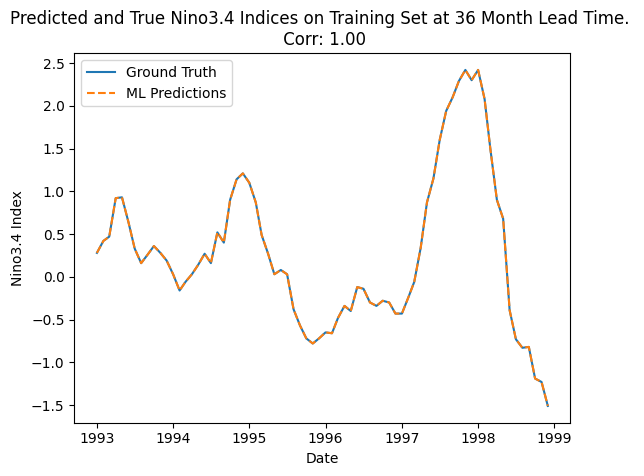

In [ ]:
#Load in the predictors
X, y = assemble_basic_predictors_predictands('1990-01-01','1995-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!


<ipython-input-9-59e6158d8d85>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X, y = X[permuted_indices], y[permuted_indices]


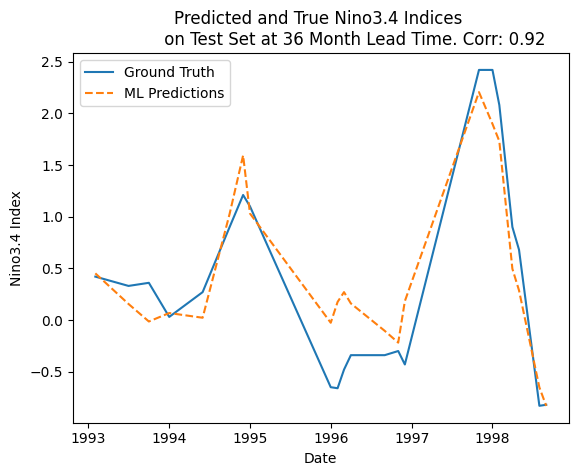

In [ ]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

What happened above? Did we just develop a 36-month ahead forecast that has 0.92 correlation on unseen data??

Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

## Exercise 1

⭐ **Your turn!:** Will performance on a true, uncorrelated test set be better or worse than performance on the biased dataset? Split the data so that the test set represents an unbiased holdout set. Ensure that you're using a 36-month lead time.

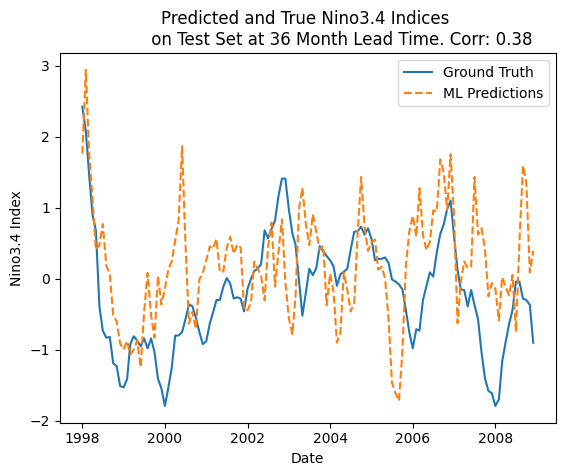

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=12)
X_test, y_test = assemble_basic_predictors_predictands('1997-01-01','2007-12-31', lead_time=12)

regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

### Solution

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=36)
X_test, y_test = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=36)

regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

On a true test set, a model making *36 month ahead* predictions does not generalize well.


# The Bias-Variance Tradeoff

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change?

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Question***
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.


Here's another example to help develop our visual understanding of bias vs. variance.

Here is how a k-Nearest-Neighbor model works:
1. The model is shown a sample data point from the test set, $x_\text{test}$
2. It searches its training set for the $k$ most similar data points
3. Of the $k$ points it founds, it calculates the most common predictand, and it assigns $x_\text{test}$ the most common

Crucially, this method supports classification of data that is not linearly separable (see below image for an example)

***Polling question:*** For a large value of $k$, would you expect a high bias/low variance classifier? Or a high variance/low bias classifier?

![alt text](http://web.cse.ohio-state.edu/~stiff.4/cse3521/images/effect-of-k.png)




Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)

*   "The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)."

*   "The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**)."

### Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term:

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above:
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$:
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Coding Exercise*: Regularization


In this example, we will investigate the real-world effect of regularization on our ENSO dataset.

Note: for visualization purposes, we do not train our models using all lat$*$lon predictors.  Instead, we use Principal Components Analysis (aka Empirical Orthogonal Functionals) to represent all lat$*$lon predictors with far fewer dimensions.  Due to time constraints, please refer to page 116 of Professor Shewchuk's notes for a deeper explanation of this method.

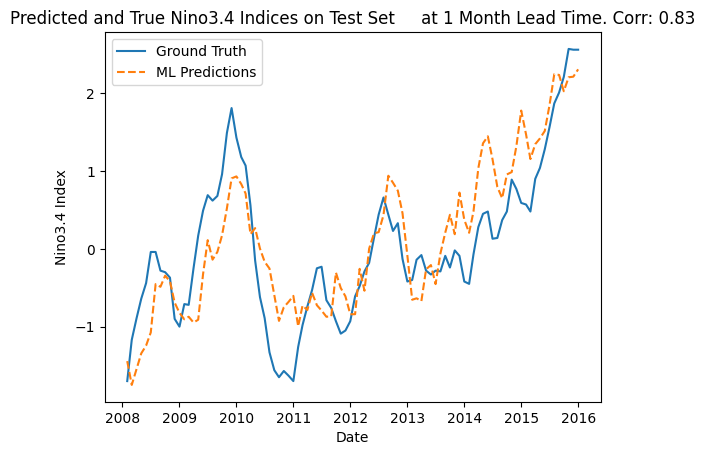

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


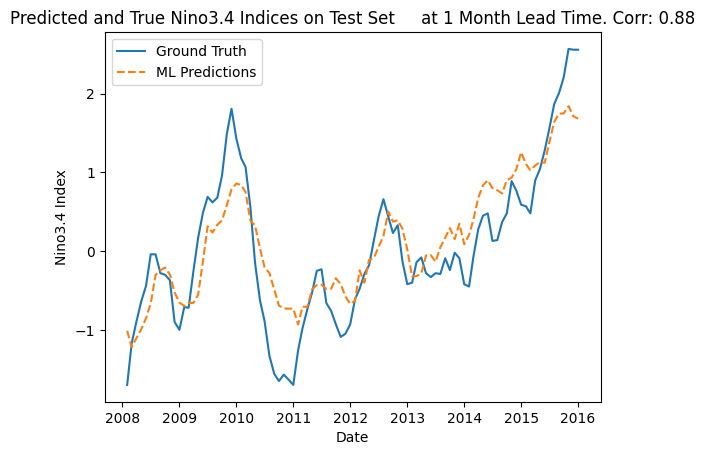

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


On the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

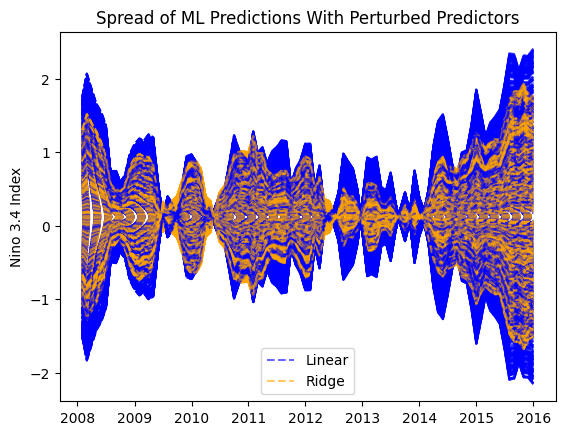

In [ ]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)

  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  

In the cell below, let's investigate why ridge regression is less vulnerable to small fluctuations in the data.

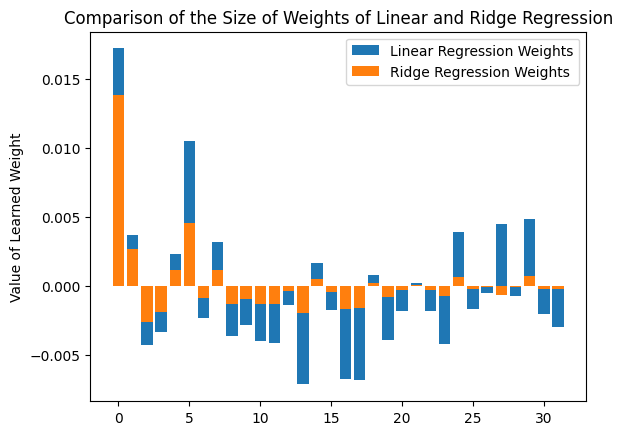

In [ ]:
"""In this cell, we will visualize how the weights of the linear
regression model are bigger than those of the ridge regression model"""

#coef_ loads in the coefficients from the trained model
regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regression')
plt.show()

As expected, the weights of the ridge regression model are smaller than those of the linear regression model.

There we have it! On our real-world ENSO dataset, we have confirmed our theoretical speculations about the effect of regularization on the bias-variance tradeoff!  

To recap:

*   Because of the regularization term, the weights in a ridge regression model are smaller (large weights are penalized during the optimization) than those in linear regression
*   With smaller weights, the ridge regression model is less vulnerable to small fluctuations in the data
*   This means that ridge regression models have less variance and are less vulnerable to overfitting

## Machine Learning Models and Model Selection

### Physics-based Machine Learning

An open problem in machine learning is how to incorporate physics into the model.  For example, some physical laws in the climate system are **conservation of mass** and **conservation of momentum.**  By including these physical laws into machine learning, we can get two possible benefits:  

*   the output of our machine learning model is consistent with physical properties (e.g. we won't have ML models predicting negative precipitation values)
*   Possibly, it may take less time to train the ML models, since we are including prior information

Incorporating physics into machine learning models is a cutting-edge research area.  For more information on this area, we suggest reading the following article:[ Physics-informed machine learning: case studies for weather and climate modelling.](https://royalsocietypublishing.org/doi/10.1098/rsta.2020.0093)

**Take home exercise:** Try incorporating physical laws into our ENSO forecasting model above!

### Variance Scaling

In the preprocessing presentation, we discussed ways that data is normalized before being fed into machine learning models.  Some models ML techniques require data to be centered (have mean 0); in other cases, normalization helps with numerical stability.  

One type of normalization is called variance scaling.  Variance scaling is to scale the variance of each predictor such that each predictor has a variance of 1.  

In our ENSO dataset, we have latxlon predictors; each predictor is temperature at a certain location on Earth.  We have ```num_time_steps``` samples of these predictors. Therefore, the shape of ```X``` is (num_time_steps, latxlon). *Variance scaling would mean that we scale our dataset such that the variance of temperature at each grid cell is 1.*

Should we use variance scaling for our ENSO forecasting model?

Acknowledgment: I'd like to  thank Professor [Patrick Brown](https://patricktbrown.org/about/) for helping me with this problem.

In [ ]:
"""Write code to explore the above question"""

'Write code to explore the above question'

## Deep Learning

Now let's try training a neural network to forecast ENSO.  In this section, we will use PyTorch as our machine learning framework.



Let's get started: first, let's load the data.  **PLEASE READ THE DOCSTRING FOR THE `assemble_predictors_predictands` function!** It is essential to understand the arguments to this function as we explore different scientific/ machine learning questions later on in this hackathon.

In this section, the `assemble_predictors_predictands` method has been extended to load in data from observations AND from GCMs.

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time,
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")


  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)


    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead,
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

**IMPORTANT info about `num_input_time_steps`:** `num_input_time_steps` refers to the number of time steps for each predictor.  For example, if `num_input_time_steps` is set to 3, then the machine learning model will take 3 months as its input.  In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)).  The predictand will be the Niño3.4 index `lead_time` months after March.

Let's define a simple convolutional neural network to start.  


## Train A Simple Convolutional Neural Network to Forecast ENSO

Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [ ]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.  

**IMPORTANT** Reading through this method will help you understand each step in the process of training a neural network!

**What would happen if you removed the lines that say `if mode == 'train'` in the code cell below?**

In [ ]:
def train_network(net, criterion, optimizer, trainloader, testloader,
                  experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()

          #Save the model weights that have the best performance!


          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))

  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)

  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.597762
test Set: Epoch 01. loss: 0.530707
train Set: Epoch 02. loss: 0.278752
test Set: Epoch 02. loss: 0.243690
train Set: Epoch 03. loss: 0.162315
test Set: Epoch 03. loss: 0.433045
train Set: Epoch 04. loss: 0.169350
test Set: Epoch 04. loss: 0.312390
train Set: Epoch 05. loss: 0.145721
test Set: Epoch 05. loss: 0.194248
train Set: Epoch 06. loss: 0.135570
test Set: Epoch 06. loss: 0.175499
train Set: Epoch 07. loss: 0.099940
test Set: Epoch 07. loss: 0.166007
train Set: Epoch 08. loss: 0.086797
test Set: Epoch 08. loss: 0.168364
train Set: Epoch 09. loss: 0.078006
test Set: Epoch 09. loss: 0.176404
train Set: Epoch 10. loss: 0.095574
test Set: Epoch 10. loss: 0.432030
train Set: Epoch 11. loss: 0.069558
test Set: Epoch 11. loss: 0.588473
train Set: Epoch 12. loss: 0.066691
test Set: Epoch 12. loss: 0.323184
train Set: Epoch 13. loss: 0.089330
test Set: Epoch 13. loss: 0.178795
train Set: Epoch 14. loss: 0.080932
test Set: Epoch 14. loss: 0.147282
train 

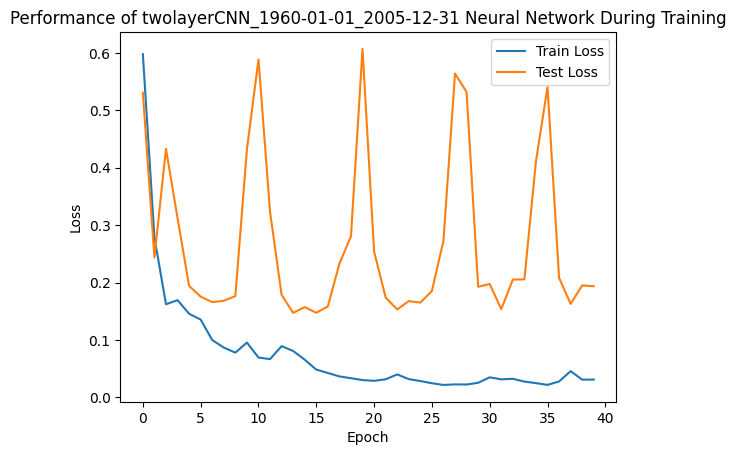

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

*Check your understanding:* From the previous section on fundamentals of machine learning, what is it called when the validation losses are very high and the train losses are very low?  What might we try to reduce this problem?

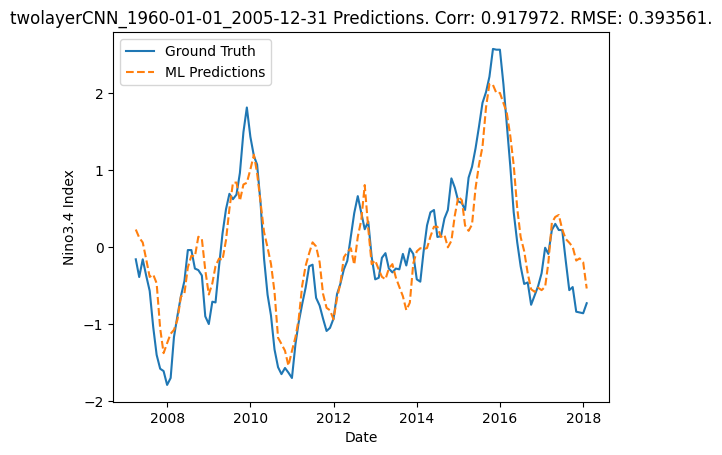

In [ ]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

## Exercise 2

⭐ **Your turn!:** Try reducing the number of parameters of the network. You could define your own network architecture, which uses a different number of parameters!

In [ ]:
# first we'll install a helpful library to sum our parameters
!pip install torchinfo

In [ ]:
from torchinfo import summary

# let's see how many parameters our original CNN has
summary(net)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            114
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Print: 1-4                             --
├─Linear: 1-5                            7,015,800
├─Linear: 1-6                            10,164
├─Linear: 1-7                            85
Total params: 7,028,579
Trainable params: 7,028,579
Non-trainable params: 0

In [ ]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNNReduced, self).__init__()

        ### YOUR CODE HERE ###

        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):

        ### YOUR CODE HERE ###

        return x

In [ ]:
net_reduced = CNNReduced(num_input_time_steps=num_input_time_steps)
summary(net_reduced)

In [ ]:
optimizer = optim.Adam(net_reduced.parameters(), lr=0.0001)

experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net_reduced, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

In [ ]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

### Solution



In this possible solution, we simply adjust the number of output layers from both the first and second linear layers.

In [ ]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNNReduced, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 80)
        self.fc2 = nn.Linear(80, 42)
        self.fc3 = nn.Linear(42, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net_reduced = CNNReduced(num_input_time_steps=num_input_time_steps)
summary(net_reduced)

Layer (type:depth-idx)                   Param #
CNNReduced                               --
├─Conv2d: 1-1                            114
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Print: 1-4                             --
├─Linear: 1-5                            4,677,200
├─Linear: 1-6                            3,402
├─Linear: 1-7                            43
Total params: 4,683,175
Trainable params: 4,683,175
Non-trainable params: 0

In [ ]:
optimizer = optim.Adam(net_reduced.parameters(), lr=0.0001)

experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net_reduced, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.681152
test Set: Epoch 01. loss: 0.811947
train Set: Epoch 02. loss: 0.555721
test Set: Epoch 02. loss: 0.490539
train Set: Epoch 03. loss: 0.240406
test Set: Epoch 03. loss: 0.202864
train Set: Epoch 04. loss: 0.146935
test Set: Epoch 04. loss: 0.273602
train Set: Epoch 05. loss: 0.119005
test Set: Epoch 05. loss: 0.258730
train Set: Epoch 06. loss: 0.113395
test Set: Epoch 06. loss: 0.127528
train Set: Epoch 07. loss: 0.107295
test Set: Epoch 07. loss: 0.129498
train Set: Epoch 08. loss: 0.109800
test Set: Epoch 08. loss: 0.184788
train Set: Epoch 09. loss: 0.074524
test Set: Epoch 09. loss: 0.309736
train Set: Epoch 10. loss: 0.065992
test Set: Epoch 10. loss: 0.216250
train Set: Epoch 11. loss: 0.060445
test Set: Epoch 11. loss: 0.185377
train Set: Epoch 12. loss: 0.070338
test Set: Epoch 12. loss: 0.258433
train Set: Epoch 13. loss: 0.057253
test Set: Epoch 13. loss: 0.264061
train Set: Epoch 14. loss: 0.051177
test Set: Epoch 14. loss: 0.190822
train 

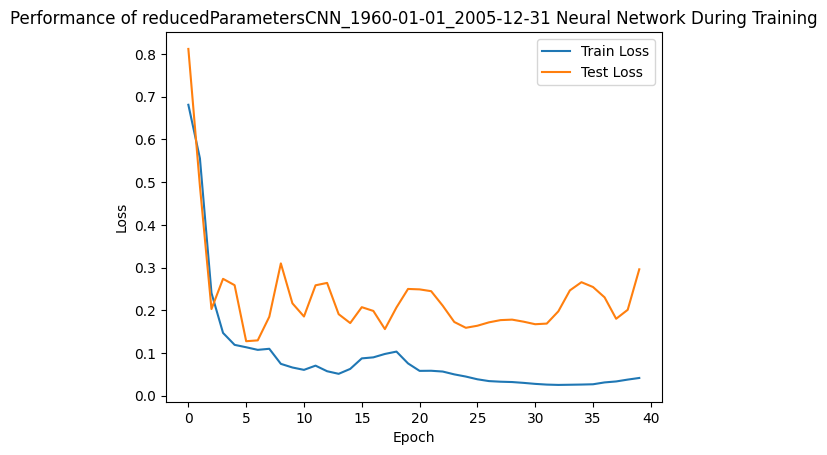

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

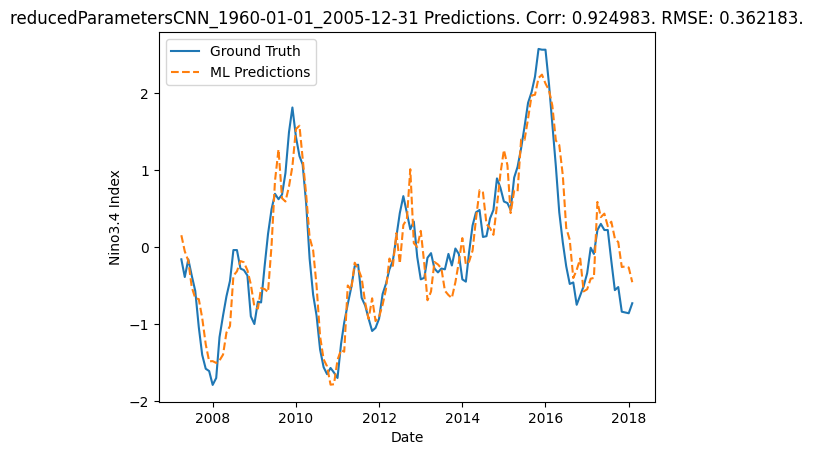

In [ ]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

We see that this new architecture lowered the losses on the validation set and also lowered our RMSE by about 0.03.

## Exercise 3

⭐ **Your turn!:** Try using traditional ML models from sklearn for this task.  Note that these algorithms do not take advantage of the spatial nature of gridded datasets.  Therefore, they require the `data_format` argument to be set to 'flatten': the predictors are in the shape `(num_samples,lat*lon*num_time_steps)`.

In [ ]:
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 1
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten',
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten',
                    num_input_time_steps=num_input_time_steps)

In [ ]:
# use sklearn's linear regression algorithm
regr_1_month_lr = ### YOUR CODE HERE ###
regr_1_month_lr.fit(### YOUR CODE HERE ###)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

In [ ]:
# now try using sklearn's random forest regression algorithm
# HINT: you may need to play around with the algorithm's hyperparameters
regr_1_month_rf = ### YOUR CODE HERE ###
regr_1_month_rf.fit(### YOUR CODE HERE ###)

sklearn_predictions_rf = regr_1_month_rf.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions_rf, test_predictands)
rmse = mean_squared_error(sklearn_predictions_rf, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions_rf,
    'Random Forest Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

### Solution

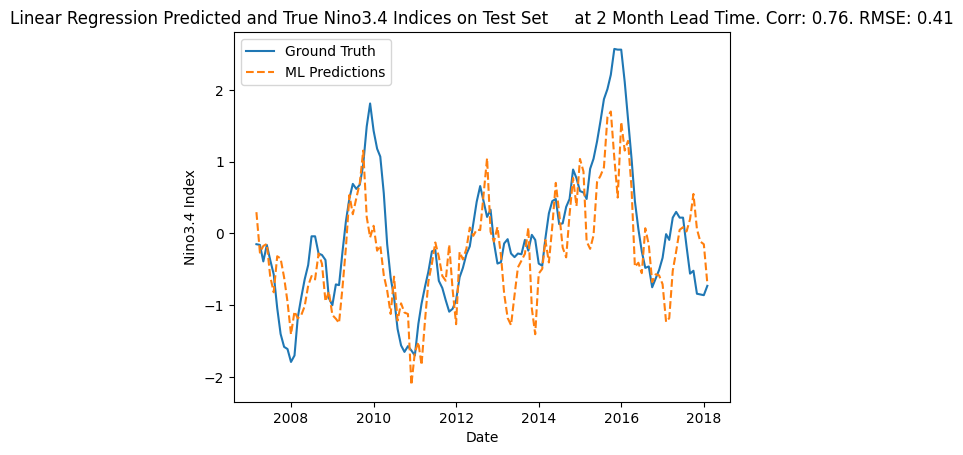

In [ ]:
# use sklearn's linear regression algorithm
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors, train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

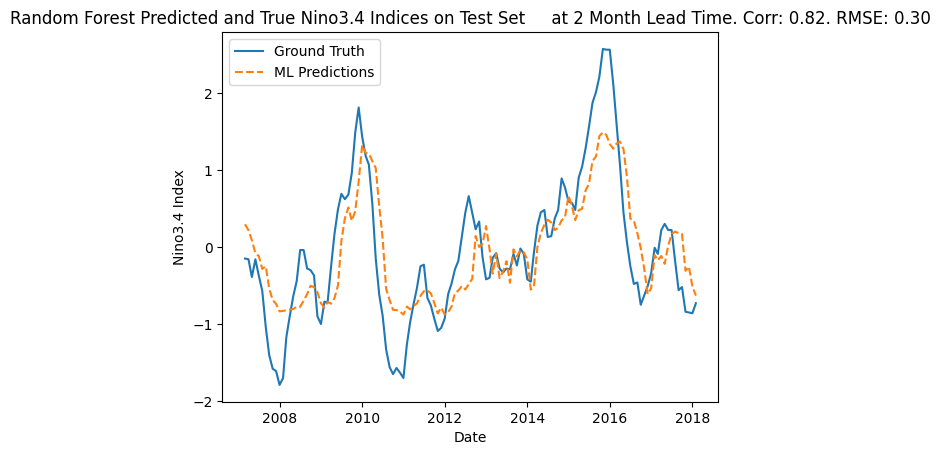

In [ ]:
# now try using sklearn's random forest regression algorithm
regr_1_month_rf = sklearn.ensemble.RandomForestRegressor(max_depth=2, random_state=0)
regr_1_month_rf.fit(train_predictors, train_predictands)

sklearn_predictions_rf = regr_1_month_rf.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions_rf, test_predictands)
rmse = mean_squared_error(sklearn_predictions_rf, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions_rf,
    'Random Forest Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

We see significantly better performance with the random forest model!

## Challenge Exercise: What data sources improve the ML algorithm? What data sources do not improve the ML algorithm?

Let's try training our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset.  There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

**GOAL OF THIS EXERCISE**: generate two plots: one showing the time series of predicted and true Niño3.4 indices with an ML model trained on 1900-1930 data.  The other should show the same (time series of prediced and true Niño3.4 indices with a model trained on 1975-2005 data.  (Both trained algorithms should be tested on data from 2007-2018.)

In [ ]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
  """YOUR CODE HERE"""
  #Replicate the logic in the Exercise 1 and Exercise 2 to explore
  #how well a CNN or traditional ML model does with the start
  #and end dates defined above!  Plot the performance of the models!

## Challenge Exercise: Data wrangling: Do machine learning algorithms perform better with a classification problem or regression problem?

Convert the problem from regression (predicting a continuous value) to classification (predicting a discrete value).  

Let's bin the Niño3.4 index to two values: 0 and 1.  Let's say negative values of the Niño3.4 index should be mapped to 0 and positive values of the index should be mapped to 1.

### Goal of the exercise:

Train a neural network and an sklearn logistic regression model to predict 0 or 1 corresponding to the mapping above!  

You have to change the neural network's loss function from `nn.MSELoss` to `nn.BCEWithLogitsLoss`!

In [ ]:
#1.Adjust the train_network method so that the target is always 0 or 1. Maybe add an
# argument called "classification" that takes in a boolean value indicating
# whether or not to map the target to 0 or 1.
#2. Change the loss function of the neural network
#3. Run the train_network method to get the neural network predictions
#4. You will have to write your own code to calculate the accuracy of these predictions!

# Challenge Exercise: Get the best ENSO forecasting algorithm!  (Tip: check out ensembling between algorithms and try hyperparameter tuning.)

Do deeper neural networks with more convolutional layers help?
Try changing the hyperparameters of the neural network

*   learning rate
*   the choice of optimizer
*   the size of the convolution filters
*   the number of convolution filters
*   the number of weights in the fully connected layers

There are other data preprocessing parameters that may improve the performance of your forecasting algorithm:

*  training your ML model on a specific latitude or longitude "slice", as opposed to the whole globe
*  Ensembling predictions from multiple different algorithms! For example, you could average the prediction from random forests, artificial neural networks,  convolutional neural networks, and/ or any other machine learning model .

Recall from the previous notebook: models with many parameters (i.e. very deep neural networks or very deep decision trees) are more likely to have very low bias and very high variance: they will likely overfit!


*Develop a Nino3.4 Forecasting system for a lead_time of 5 months?* If you would like, submit your results to the kaggle link:

Details of the kaggle competition: just like in the first code cell, we will test our code on data from 2007-01-01 to 2017-12-31.  The data loader is reproduced below!  There are 131 predictor/predictand pairs between these dates.  Therefore, your entry should be exactly 131 numbers!  

In [ ]:
#Select the data parameters for your model(s)!
lead_time = 5
data_format = raise NotImplementedError("Select a data format for your kaggle entry! See docstring of `assemble_predictors_predictands` for description of data_format.")
lat_slice = raise NotImplementedError("Select a lat slice for your kaggle entry!")
lon_slice = raise NotImplementedError("Select a lon slice for your kaggle entry!")
num_input_time_steps = 3 #Do not change this!
use_pca = raise NotImplementedError("You decide if you would like to use PCA on the input predictors!")
n_components = raise NotImplementedError("If use_pca=True, You decide how many principal components to use on the input predictors!")
train_predictors, train_predictands = """YOUR CODE HERE: assemble predictors predictands how you see fit"""

train_predictors, train_predictands = assemble_predictors_predictands('YOUR CHOICE OF START DATE',
                    'YOUR CHOICE OF END DATE', lead_time=5, dataset='observations',
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)
#Do not change the line below for your kaggle submission
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations',
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)

#If using deep learning:
# create an ENSODataset and DataLoader
#object (see code cell in Exercise 1) and use the `train_network` method to
#extract predictions!
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
cnn_predictions, _, _ = train_network()


#If using regular traditional ML with sklearn:
sklearn_model = #choose sklearn model
sklearn_model.fit(train_predictors,train_predictands)

sklearn_predictions = sklearn_model.predict(test_predictors)


#Ensemble predictions from multiple algorithms
#(i.e. take the average of predictions from multiple algorithms!)
predictions = (cnn_predictions +sklearn_predictions)/2.0



#Hackathon Exercise:  Do climate models serve as a source of training data?

A paper by [Ham et. al.](https://www.nature.com/articles/s41586-019-1559-7) trains a convolutional neural network to forecast ENSO, and it trains the model on both observations and **simulations from the Climate Model Intercomparison Project** (CMIP).

Try the following process:


1.   Download a given model's simulations from CMIP5 or CMIP6: the desired variable is "sst," because that is the observation variable that we use.
2.   Regrid the model resolution to 180 x 360: xESMF is a great package for regridding
3.   Include the regridded data into the training workflow.  See the `dataset` parameter of `assemble_predictors_predictands` for a possible way to include simulated data into the dataloading and training workflow.

If you would like to use preprocessed model data (skipping steps 1 and 2), I have prepared some available through the lines below.  Please note that these models use `tas` (surface temperature), not `sst` (sea surface temperature). `tas` is a different input variable and includes temperatures over land as input.



In [ ]:
#Download CNRM tas anomalies
!gdown 1ecrHyViNi6GeuUpCUJVGQsxvdyxzlSnY


Downloading...
From: https://drive.google.com/uc?id=1ecrHyViNi6GeuUpCUJVGQsxvdyxzlSnY
To: /content/CNRM_tas_anomalies_regridded.nc
100% 5.29G/5.29G [00:20<00:00, 253MB/s]


In [ ]:
#Download MPI tas anomalies
!gdown 1vhb3fnIMXa7jyt29fOpy3n0aifSOORtr

Downloading...
From: https://drive.google.com/uc?id=1vhb3fnIMXa7jyt29fOpy3n0aifSOORtr
To: /content/MPI_tas_anomalies_regridded.nc
100% 6.22G/6.22G [01:46<00:00, 58.2MB/s]


# Additional Reading Material After This Tutorial

To supplement this tutorial, I have included topics on traditional machine learning that I think are crucial for all ML practitioners in climate science to know.  

1. What is boosting? Why is it necessary and how does it help? (Prof. Shewchuk pg. 147, Nasiriany pg. 169)

2. How do traditional ML models work? Logistic regression (Nasiriany pg. 113), random forests (Nasiriany pg. 163), and support vector machines (Nasiriany pg. 127)

3. What strategies help alleviate challenges of data being linearly inseparable? (Professor Shewchuk pg. 20) What is the kernel trick? How does it help with this challenge? (Prof. Shewchuk pg. 76)

4. Gradient Descent and Newton's method (Nasiriany pg. 82 and 93)

# Challenge Exercise: Physical Interpretability

One important aspect of machine learning in climate science is physical interpretability!  We want to understand what our model is doing under the hood as well as possible.  Why is the model making its predictions?  What information is it using to make them.  In linear regression, one way to interpret the model is to visualize the learned regression weights.

In the code cells below, we train a linear regression model to predict ENSO, and then we visualize the learned regression weights.

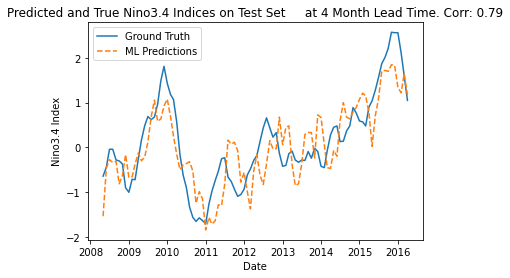

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                4)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 4,
                                                  )
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 4 Month Lead Time. Corr: {:.2f}'.format(corr))


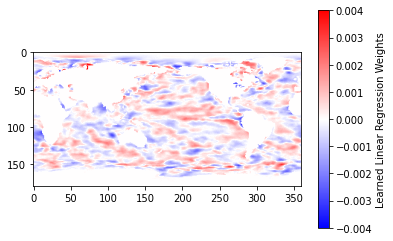

In [ ]:
#The weights have shape (64800,) because the 2D (lat x lon) field
#has been flattened into a 1D vector in order to perform linear regression
#To visualize the weights, we set them back into (lat x lon) field
#to see the spatial distribution of the weights
regr_1_month_lr_weights = regr_1_month_lr.coef_.reshape((180,360))

plt.imshow(regr_1_month_lr_weights, cmap='bwr', vmin=-0.004, vmax=0.004)
cb = plt.colorbar()
cb.set_label("Learned Linear Regression Weights")

**Try to use other physical interpretability methods for other ML models (e.g. neural networks or random forests)**.  For neural networks, one example of a method is Layerwise Relevance Propogation.  See  [Barnes et. al.](https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2019GL084944) and [Toms et. al](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2019MS002002) for a demonstration of this method in climate science, related to climate change and climate variability.

 See this paper from [Mamalakis et. al](https://arxiv.org/ftp/arxiv/papers/2103/2103.10005.pdf). for an overview and comparison of different physical interpretability methods that could be used in an ML for climate science problem.

How do the physical interpretability methods compare to visualizing the linear regression weights?  Why might this be the case

# Additional Problems

1. Classification vs. Regression!  In this notebook, we treated ENSO forecasting as a regression problem.  When the Nino3.4 Index is above 0.5 for 5 consecutive months, then there is an El Nino. When the Nino3.4 Index is below 0.5 for 5 consecutive months, then there is an La Nina. The lines of code below implement this labelling.
```
_, y = assemble_predictors_predictands('1990-01-01','2005-12-31',1)
y_el_nino_binary = (y > 0.5).rolling(window=5).min()
y_la_nina_binary = (y < 0.5).rolling(window=5).min()
y_classification = pd.Series(np.zeros(y_el_nino_binary.shape),
                        index=y.index)
y_classification[y_el_nino_binary == 1.0] = 2
y_classification[y_la_nina_binary == 1.0] = 1                   
```
```y_classification``` has three values (2,1,0), indicating if the event is El Nino, La Nina, or neither.  In this notebook, we have treated ```y``` has a continuous value.  If we treat it as a discrete value, can we use linear classifiers to forecast ENSO more accurately? If we treat it as a discrete value, can we use deep learning classifiers to forecast ENSO more accurately?

2. Import the decision tree and RF classifier from scikit-learn and try to forecast ENSO! How do these models perform compare to the models we used in this tutorial?
